In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input
from sklearn.metrics import mean_squared_error, mean_absolute_error
import emlearn

In [2]:
# Load the dataset
dataset = pd.read_csv("dataset/radiation_data_15min.csv")

In [3]:
# Preprocessing function
def preprocess(df):
    
    df = df.copy()
    
    # Convert 'time' column to datetime
    df['time'] = pd.to_datetime(df['time'])
    
    # Extract basic temporal features
    df['hour'] = df['time'].dt.hour
    df['minute'] = df['time'].dt.minute
    df['weekofyear'] = df['time'].dt.isocalendar().week
    
    # Encode cyclical features using sine and cosine
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['min_sin'] = np.sin(2 * np.pi * df['minute'] / 60)
    df['min_cos'] = np.cos(2 * np.pi * df['minute'] / 60)
    df['woy_sin'] = np.sin(2 * np.pi * (df['weekofyear'] - 1) / 52)
    df['woy_cos'] = np.cos(2 * np.pi * (df['weekofyear'] - 1) / 52)
    
    return df

In [4]:
# Apply preprocessing to the entire dataset first
dataset = preprocess(dataset)

# Split into train and test sets
train = dataset[dataset['time'] < "2023-01-01"]
test = dataset[dataset['time'] >= "2023-01-01"]

In [5]:
# Features and Target
features = [
    'Gb(i)','Gd(i)','Gr(i)','H_sun','T2m','WS10m',
    'hour_sin','hour_cos','min_sin','min_cos','woy_sin','woy_cos'
]

target = ['P']

In [6]:
# Initialize scalers for features and target
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit scalers on training data and transform
X_train_scaled = scaler_X.fit_transform(train[features])
y_train_scaled = scaler_y.fit_transform(train[target])

# Transform test data using the same scalers
X_test_scaled = scaler_X.transform(test[features])
y_test_scaled = scaler_y.transform(test[target])

# Print min and max values, used by C code for dongles to scale input data correctly for the model
print("Feature min:", scaler_X.data_min_)
print("Feature max:", scaler_X.data_max_)
print("Target min:", scaler_y.data_min_)
print("Target max:", scaler_y.data_max_)

Feature min: [ 0.         0.         0.         0.        -3.29       0.
 -1.        -1.        -0.8660254 -0.8660254 -1.        -1.       ]
Feature max: [9.73990000e+02 4.36640000e+02 2.04000000e+01 6.96300000e+01
 3.40700000e+01 1.13800000e+01 1.00000000e+00 1.00000000e+00
 8.66025404e-01 8.66025404e-01 1.00000000e+00 1.00000000e+00]
Target min: [0.]
Target max: [111750.]


In [7]:
LOOK_BACK = 8     # Past steps (2 hours history at 15-min intervals)
HORIZON = 8       # Future steps (2 hours forecast at 15-min intervals)

def create_sequences(X, y, look_back=LOOK_BACK, horizon=HORIZON):
    Xs, ys = [], []
    for i in range(len(X) - look_back - horizon + 1):
        Xs.append(X[i:i + look_back])                  # Past window
        ys.append(y[i + look_back : i + look_back + horizon].flatten())  # Next horizon
    return np.array(Xs), np.array(ys)

# Generate training and test sequences
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled)
X_test_seq,  y_test_seq  = create_sequences(X_test_scaled, y_test_scaled)

In [8]:
# Flatten sequences for feed-forward model (2D input required)
n_features = X_train_seq.shape[2]   # number of features per time step
X_train_flat = X_train_seq.reshape(X_train_seq.shape[0], LOOK_BACK * n_features)
X_test_flat  = X_test_seq.reshape(X_test_seq.shape[0], LOOK_BACK * n_features)

In [9]:
# Feed-forward neural network for multi-step forecasting
def build_ffnn_model(input_shape, horizon):
    model = Sequential([
        Input(shape=(input_shape,)),
        Dense(64, activation='relu'),  # first hidden layer
        Dropout(0.2),                                              # regularization
        Dense(32, activation='relu'),                              # second hidden layer
        Dense(horizon, activation='relu')                          # output: horizon steps
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Build and summarize model
model = build_ffnn_model(LOOK_BACK * n_features, HORIZON)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,552 (33.41 KB)

 Trainable params: 8,552 (33.41 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Early stopping to avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train_flat, y_train_seq,
    epochs=50,
    batch_size=32,
    validation_split=0.2,   # use last 20% of training as validation
    callbacks=[early_stop],
    shuffle=False,          # keep time order
    verbose=1
)

Epoch 1/50
4382/4382 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.0182 - mae: 0.0573 - val_loss: 0.0108 - val_mae: 0.0566
Epoch 2/50
4382/4382 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 0.0050 - mae: 0.0337 - val_loss: 0.0101 - val_mae: 0.0545
Epoch 3/50
4382/4382 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - loss: 0.0046 - mae: 0.0316 - val_loss: 0.0086 - val_mae: 0.0491
Epoch 4/50
4382/4382 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 0.0044 - mae: 0.0307 - val_loss: 0.0082 - val_mae: 0.0474
Epoch 5/50
4382/4382 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 0.0042 - mae: 0.0299 - val_loss: 0.0070 - val_mae: 0.0440
Epoch 6/50
4382/4382 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0041 - mae: 0.0293 - val_loss: 0.0071 - val_mae: 0.0440
Epoch 7/50
4382/4382 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0040 - mae: 0.0288 - val_loss: 0.0075 - val_mae: 0.0453
Epoch 8/50
4382/4382 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.0040 - mae: 0.0285 - val_loss: 0.0071 - val_mae: 0.0444
Epoch 9/50
4382/4382 ━━━━━━━━━━━

In [11]:
# Predict on test set (scaled output)
y_pred_scaled = model.predict(X_test_flat)

# Inverse transform (scaler_y was fit on 1D target)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).reshape(-1, HORIZON)
y_true = scaler_y.inverse_transform(y_test_seq.reshape(-1, 1)).reshape(-1, HORIZON)

# Step-wise metrics (for each horizon step)
for h in range(HORIZON):
    mse_h = mean_squared_error(y_true[:, h], y_pred[:, h])
    mae_h = mean_absolute_error(y_true[:, h], y_pred[:, h])
    print(f"Horizon {h+1}: MSE={mse_h:.3f}, MAE={mae_h:.3f}")

# Overall metrics across all horizons
mse_all = mean_squared_error(y_true.ravel(), y_pred.ravel())
mae_all = mean_absolute_error(y_true.ravel(), y_pred.ravel())
print(f"\nOverall: MSE={mse_all:.3f}, MAE={mae_all:.3f}")

1095/1095 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Horizon 1: MSE=18533235.142, MAE=2309.269
Horizon 2: MSE=28653260.663, MAE=2916.936
Horizon 3: MSE=46750843.722, MAE=3707.349
Horizon 4: MSE=67775734.127, MAE=4433.668
Horizon 5: MSE=86905586.945, MAE=5060.095
Horizon 6: MSE=103974671.139, MAE=5588.936
Horizon 7: MSE=119381545.962, MAE=6039.590
Horizon 8: MSE=133639317.775, MAE=6438.437

Overall: MSE=75701774.434, MAE=4561.785


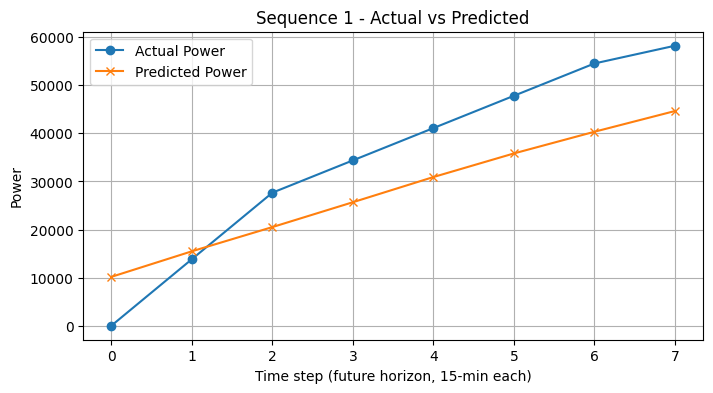

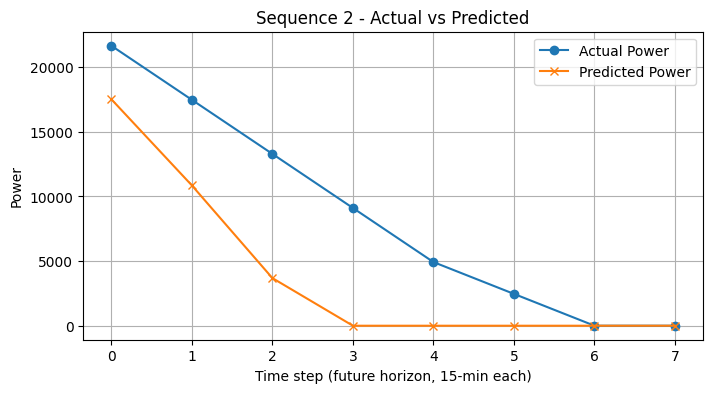

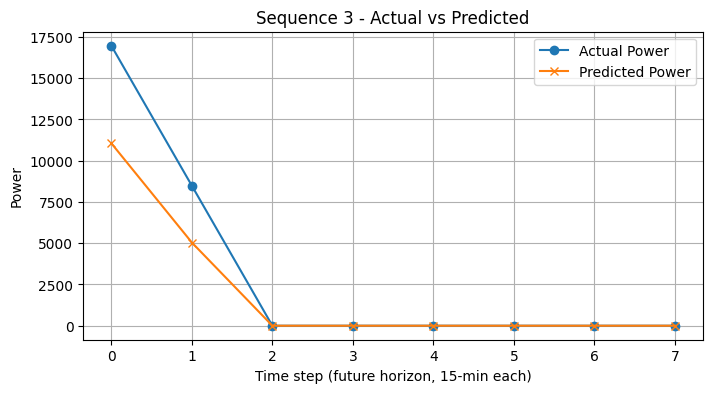

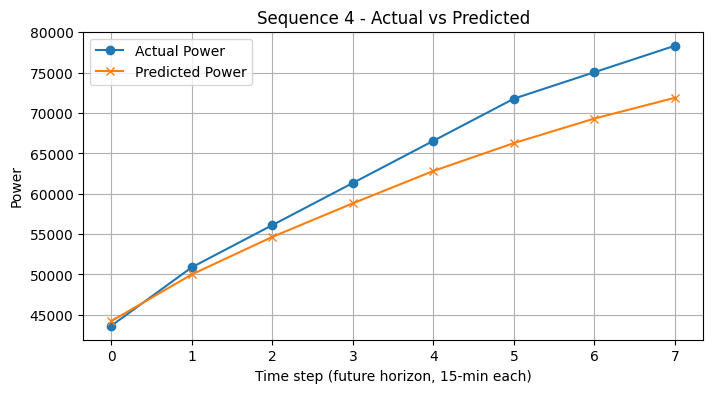

In [12]:
# --- Plot some random sequences ---
indices = [30162, 11000, 31636, 3959]

for idx, i in enumerate(indices, 1):
    # Select true and predicted values for this sequence
    y_true_i = y_true[i]   # actual values
    y_pred_i = y_pred[i]   # predicted values

    # Plot actual vs predicted
    plt.figure(figsize=(8, 4))
    plt.plot(range(HORIZON), y_true_i, marker='o', label='Actual Power')
    plt.plot(range(HORIZON), y_pred_i, marker='x', label='Predicted Power')
    plt.title(f'Sequence {idx} - Actual vs Predicted')
    plt.xlabel('Time step (future horizon, 15-min each)')
    plt.ylabel('Power')
    plt.legend()
    plt.grid(True)
    plt.show()

In [13]:
# Convert Keras model to emlearn format for deployment on microcontrollers
emlearn_model = emlearn.convert(model, method='inline')

# Save the converted model as a C header file
emlearn_model.save(file="../sensorPV/emlearnModel.h", name='emlearnModel')

'\n#include <eml_net.h>\nstatic const float emlearnModel_layer_0_biases[64] = { 0.025298f, -0.008173f, 0.000000f, 0.102097f, -0.010074f, -0.007669f, 0.050461f, -0.036396f, -0.051516f, -0.121248f, -0.015278f, -0.038200f, 0.193149f, -0.015652f, 0.210602f, -0.110877f, -0.049921f, -0.032336f, 0.001446f, -0.021288f, 0.098972f, -0.005346f, 0.031732f, 0.118050f, -0.007233f, -0.036202f, -0.101228f, -0.023142f, -0.022964f, -0.108633f, -0.043548f, -0.039125f, -0.215532f, 0.085229f, -0.181116f, -0.070444f, -0.037530f, -0.054324f, -0.060695f, -0.018845f, -0.016770f, 0.063057f, -0.015192f, -0.078348f, -0.109123f, -0.011446f, 0.041584f, 0.045005f, -0.011984f, 0.078362f, -0.063882f, -0.160128f, -0.234099f, -0.036035f, -0.218312f, 0.145164f, -0.116610f, -0.034092f, -0.000889f, -0.044281f, -0.033931f, -0.000349f, -0.016892f, -0.028923f };\nstatic const float emlearnModel_layer_0_weights[6144] = { -0.554816f, 0.075885f, -0.165137f, 0.148031f, -0.086496f, -0.039740f, -0.192086f, 0.010761f, -0.118558f, -0